/home/bld/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22352 (\N{CJK UNIFIED IDEOGRAPH-5750}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/bld/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/bld/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26080 (\N{CJK UNIFIED IDEOGRAPH-65E0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/bld/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/bld/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from fon

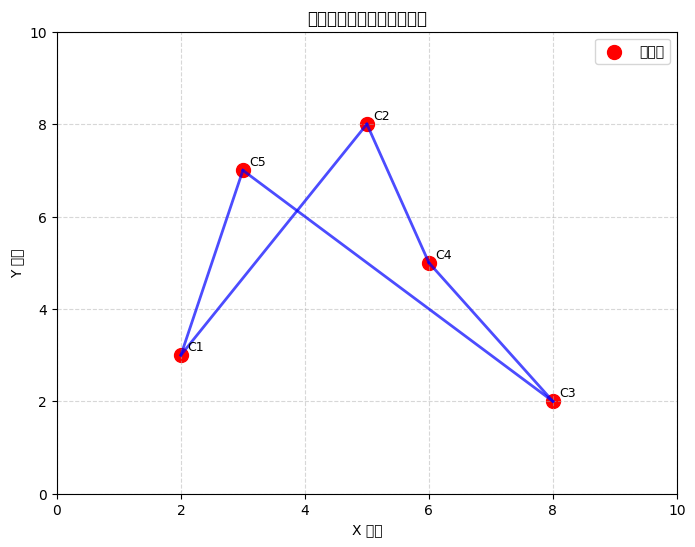

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据：假设配送柜的位置（经纬度或简化为二维坐标）
cabin_positions = np.array([
    [2, 3],
    [5, 8],
    [8, 2],
    [6, 5],
    [3, 7]
])

# 无人机航线：每条航线用起点和终点表示
routes = [
    (cabin_positions[0], cabin_positions[1]),
    (cabin_positions[1], cabin_positions[3]),
    (cabin_positions[3], cabin_positions[2]),
    (cabin_positions[2], cabin_positions[4]),
    (cabin_positions[4], cabin_positions[0])
]

# 绘图
plt.figure(figsize=(8, 6))
plt.title("无人机配送柜及航线示意图")

# 绘制城市区域示意背景（可以根据需要绘制更详细的地图背景）
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.grid(True, linestyle='--', alpha=0.5)

# 绘制配送柜位置
plt.scatter(cabin_positions[:, 0], cabin_positions[:, 1], s=100, c='red', label='配送柜')

# 标注各个配送柜
for i, (x, y) in enumerate(cabin_positions):
    plt.text(x+0.1, y+0.1, f'C{i+1}', fontsize=9, color='black')

# 绘制航线：可以绘制为直线或弧形曲线（此处为直线连接）
for (start, end) in routes:
    # 如果需要曲线效果，可以使用贝塞尔曲线或样条曲线拟合
    plt.plot([start[0], end[0]], [start[1], end[1]], 'b-', lw=2, alpha=0.7)

plt.legend()
plt.xlabel("X 坐标")
plt.ylabel("Y 坐标")
plt.show()


In [26]:
import xml.etree.ElementTree as ET
import math

# stops.xml 路径
stops_file = "stops_1000.xml"
output_file = "network.xml"

# 起点 stop ID（从这个 stop 出发连接到其他 stops）
source_stop_id = "stop_220"

# 读取 stops.xml
tree = ET.parse(stops_file)
root = tree.getroot()

# 提取所有 stop 信息
stops = {}
for stop in root.findall(".//stopFacility"):
    stop_id = stop.attrib["id"]
    x = float(stop.attrib["x"])
    y = float(stop.attrib["y"])
    stops[stop_id] = {"x": x, "y": y}

# 获取 source stop 坐标
source = stops[source_stop_id]
source_x, source_y = source["x"], source["y"]

# 创建 network 结构
network = ET.Element("network")
nodes = ET.SubElement(network, "nodes")
links = ET.SubElement(network, "links")

# 添加所有 node
for stop_id, coord in stops.items():
    ET.SubElement(nodes, "node", id=stop_id, x=str(coord["x"]), y=str(coord["y"]))

# 添加 links（从 source_stop_id 指向其他 stop）
link_id_counter = 1
for stop_id, coord in stops.items():
    if stop_id == source_stop_id:
        continue
    # 计算距离
    dx = coord["x"] - source_x
    dy = coord["y"] - source_y
    distance = math.sqrt(dx**2 + dy**2)

    ET.SubElement(links, "link", attrib={
    "id": str(link_id_counter),
    "from": source_stop_id,
    "to": stop_id,
    "length": f"{distance:.6f}",
    "freespeed": "13.8",
    "capacity": "800.0",
    "permlanes": "1.0",
    "oneway": "1",
    "modes": "car"
})
    link_id_counter += 1

# 写入 network.xml 文件
with open(output_file, "wb") as f:
    f.write(b'<?xml version="1.0" encoding="UTF-8"?>\n')
    f.write(b'<!DOCTYPE network SYSTEM "http://www.matsim.org/files/dtd/network_v2.dtd">\n')
    ET.ElementTree(network).write(f, encoding="utf-8")


In [22]:
import xml.etree.ElementTree as ET
import pyproj
import numpy as np
import math

def convert_coordinates(lng, lat):
    """Convert WGS84 coordinates to EPSG:32649."""
    transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:32649", always_xy=True)
    return transformer.transform(lng, lat)

def generate_grid(top, left, bottom, right, spacing=1000):
    """Generate a grid of points within the given bounding box."""
    lng_steps = np.arange(left, right, spacing / 111320)  # Approximate degree conversion
    lat_steps = np.arange(bottom, top, spacing / 110540)
    return [(lng, lat) for lat in lat_steps for lng in lng_steps]

def parse_network_xml(file_path):
    """Parse network.xml and extract nodes and links."""
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    nodes = {}
    for node in root.findall(".//node"):
        node_id = node.get("id")
        nodes[node_id] = (float(node.get("x")), float(node.get("y")))
    
    links = []
    for link in root.findall(".//link"):
        link_id = link.get("id")
        from_node = link.get("from")
        to_node = link.get("to")
        if from_node in nodes and to_node in nodes:
            links.append((link_id, nodes[from_node], nodes[to_node]))
    
    return links

def find_nearest_link(x, y, links):
    """Find the nearest link to a given point."""
    min_dist = float("inf")
    nearest_link = None
    
    for link_id, (x1, y1), (x2, y2) in links:
        dist = point_to_segment_distance(x, y, x1, y1, x2, y2)
        if dist < min_dist:
            min_dist = dist
            nearest_link = link_id
    
    return nearest_link

def point_to_segment_distance(px, py, x1, y1, x2, y2):
    """Calculate the distance from a point to a line segment."""
    dx, dy = x2 - x1, y2 - y1
    if dx == dy == 0:  # The segment is a point
        return math.dist((px, py), (x1, y1))
    t = max(0, min(1, ((px - x1) * dx + (py - y1) * dy) / (dx**2 + dy**2)))
    proj_x, proj_y = x1 + t * dx, y1 + t * dy
    return math.dist((px, py), (proj_x, proj_y))

def create_stop_xml(stops, output_file):
    import xml.etree.ElementTree as ET

    # 创建 XML 根节点
    transit_schedule = ET.Element("transitSchedule")
    transit_stops = ET.SubElement(transit_schedule, "transitStops")

    # 生成 stopFacility 节点
    for i, (x, y, link_ref_id) in enumerate(stops):
        ET.SubElement(
            transit_stops, "stopFacility",
            id=f"stop_{i}",
            x=str(x),
            y=str(y),
            linkRefId=link_ref_id,
            isBlocking="false"
        )

    # 生成 XML 树
    tree = ET.ElementTree(transit_schedule)

    # 添加 XML 头部声明
    with open(output_file, "wb") as f:
        f.write(b'<?xml version="1.0" encoding="UTF-8"?>\n')
        f.write(b'<!DOCTYPE transitSchedule SYSTEM "http://www.matsim.org/files/dtd/transitSchedule_v1.dtd">\n')
        tree.write(f, encoding="utf-8")

def main():
    network_file = "foshan_network.xml"
    output_file = "stops_1000.xml"
    top, left, bottom, right = 23.121157, 113.026075, 22.940317, 113.205775
    print("Generating locations...")
    locations = generate_grid(top, left, bottom, right)
    converted_locations = [convert_coordinates(lng, lat) for lng, lat in locations]
    
    print("Parsing network.xml...")
    links = parse_network_xml(network_file)
    
    print("Finding nearest links...")
    stops = [(x, y, find_nearest_link(x, y, links)) for x, y in converted_locations]
    
    print("Generating stop.xml...")
    create_stop_xml(stops, output_file)
    print(f"stop.xml generated with {len(stops)} stops.")

if __name__ == "__main__":
    main()

Generating locations...
Parsing network.xml...
Finding nearest links...
Generating stop.xml...
stop.xml generated with 420 stops.


In [14]:
import xml.etree.ElementTree as ET

def modify_freespeed(xml_file, output_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    for link in root.findall(".//link"):
        attributes = link.find("attributes")
        for attr in attributes.findall("attribute"):
            if attr.get("name") == "allowed_speed":
                allowed_speed = float(attr.text)
                if allowed_speed != None:
                    attr.text = "13.8"
    
    tree.write(output_file, encoding="utf-8", xml_declaration=True)

# 使用方法
modify_freespeed("foshan_network.xml", "foshan_network_drone.xml")


In [17]:
import xml.etree.ElementTree as ET

def parse_stops_xml(file_path):
    """Parse stops.xml and extract stopFacility coordinates."""
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    stops = []
    for stop in root.findall(".//stopFacility"):
        stop_id = stop.get("id")
        x, y = float(stop.get("x")), float(stop.get("y"))
        stops.append((stop_id, x, y))
    
    return stops

def create_network_xml(stops, output_file):
    """Generate network.xml based on stop locations."""
    network = ET.Element("network", name="generated network")
    nodes_elem = ET.SubElement(network, "nodes")
    links_elem = ET.SubElement(network, "links", capperiod="01:00:00")
    
    # Create nodes
    for stop_id, x, y in stops:
        ET.SubElement(nodes_elem, "node", id=stop_id, x=str(x), y=str(y))
    
    # Create links (simple sequential linking)
    for i in range(len(stops) - 1):
        from_id, to_id = stops[i][0], stops[i + 1][0]
        ET.SubElement(links_elem, "link", id=str(i + 1), from_=from_id, to=to_id,
                      length="500", capacity="36000", freespeed="13.8", permlanes="1")
    
    # Write to file
    tree = ET.ElementTree(network)
    with open(output_file, "wb") as f:
        f.write(b'<?xml version="1.0" encoding="UTF-8"?>\n')
        f.write(b'<!DOCTYPE network SYSTEM "http://www.matsim.org/files/dtd/network_v1.dtd">\n')
        tree.write(f, encoding="utf-8")

def main():
    stops_file = "stops.xml"
    output_network_file = "network.xml"
    
    print("Parsing stops.xml...")
    stops = parse_stops_xml(stops_file)
    
    print("Generating network.xml...")
    create_network_xml(stops, output_network_file)
    print(f"network.xml generated with {len(stops)} nodes and {len(stops) - 1} links.")

if __name__ == "__main__":
    main()

Parsing stops.xml...
Generating network.xml...
network.xml generated with 1640 nodes and 1639 links.


In [19]:
#调整网络属性，构建drone allowed speed network

import xml.etree.ElementTree as ET

def modify_freespeed(xml_file, output_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    for link in root.findall(".//link"):
        # Modify freespeed attribute
        link.set("freespeed", "13.8")
        
        # Modify allowed_speed inside attributes
        attributes = link.find("attributes")
        if attributes is not None:
            for attr in attributes.findall("attribute"):
                if attr.get("name") == "allowed_speed":
                    if float(attr.text) >= 6.9:
                        attr.text = "6.9"
    
    tree.write(output_file, encoding="utf-8", xml_declaration=True)

# Usage
modify_freespeed("foshan_network.xml", "foshan_network_drone'.xml")

In [20]:
#调整网络属性，构建rider allowed speed network

import xml.etree.ElementTree as ET

def modify_freespeed(xml_file, output_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    for link in root.findall(".//link"):
        # Modify freespeed attribute if it exceeds 6.9
        if float(link.get("freespeed", "0")) > 6.9:
            link.set("freespeed", "6.9")
        
        # Modify allowed_speed inside attributes if it exceeds 6.9
        attributes = link.find("attributes")
        if attributes is not None:
            for attr in attributes.findall("attribute"):
                if attr.get("name") == "allowed_speed" and float(attr.text) > 6.9:
                    attr.text = "6.9"
    
    tree.write(output_file, encoding="utf-8", xml_declaration=True)

# Usage
modify_freespeed("foshan_network.xml", "foshan_network_rider.xml")


In [35]:
import xml.etree.ElementTree as ET
import pyproj
import math

# 定义6个指定的WGS84坐标点（lat, lng）
coordinates_wgs84 = [
    (22.5965,113.9623),
    (22.5948, 113.9723),
    (22.5914,113.9875),
    (22.5934,113.9948),
    (22.5964,113.9986),
    (22.5839, 113.9502)
]

def convert_coordinates(lng, lat):
    transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:32649", always_xy=True)
    return transformer.transform(lng, lat)

def parse_network_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    nodes = {}
    for node in root.findall(".//node"):
        node_id = node.get("id")
        nodes[node_id] = (float(node.get("x")), float(node.get("y")))
    
    links = []
    for link in root.findall(".//link"):
        link_id = link.get("id")
        from_node = link.get("from")
        to_node = link.get("to")
        if from_node in nodes and to_node in nodes:
            links.append((link_id, nodes[from_node], nodes[to_node]))
    
    return links

def point_to_segment_distance(px, py, x1, y1, x2, y2):
    dx, dy = x2 - x1, y2 - y1
    if dx == dy == 0:
        return math.dist((px, py), (x1, y1))
    t = max(0, min(1, ((px - x1) * dx + (py - y1) * dy) / (dx**2 + dy**2)))
    proj_x, proj_y = x1 + t * dx, y1 + t * dy
    return math.dist((px, py), (proj_x, proj_y))

def find_nearest_link(x, y, links):
    min_dist = float("inf")
    nearest_link = None
    for link_id, (x1, y1), (x2, y2) in links:
        dist = point_to_segment_distance(x, y, x1, y1, x2, y2)
        if dist < min_dist:
            min_dist = dist
            nearest_link = link_id
    return nearest_link

def create_stop_xml(stops, output_file):
    transit_schedule = ET.Element("transitSchedule")
    transit_stops = ET.SubElement(transit_schedule, "transitStops")

    for i, (x, y, link_ref_id) in enumerate(stops):
        ET.SubElement(
            transit_stops, "stopFacility",
            id=f"stop_{i}",
            x=str(x),
            y=str(y),
            linkRefId=link_ref_id,
            isBlocking="false"
        )

    tree = ET.ElementTree(transit_schedule)

    with open(output_file, "wb") as f:
        f.write(b'<?xml version="1.0" encoding="UTF-8"?>\n')
        f.write(b'<!DOCTYPE transitSchedule SYSTEM "http://www.matsim.org/files/dtd/transitSchedule_v1.dtd">\n')
        tree.write(f, encoding="utf-8")

def main():
    network_file = "cropped_network.xml"
    output_file = "custom_stops.xml"

    print("Converting coordinates...")
    converted_coords = [convert_coordinates(lng, lat) for lat, lng in coordinates_wgs84]
    print(converted_coords)
    print("Parsing network...")
    links = parse_network_xml(network_file)

    print("Finding nearest links...")
    stops = [(x, y, find_nearest_link(x, y, links)) for x, y in converted_coords]

    print("Creating stop XML...")
    create_stop_xml(stops, output_file)
    print(f"{len(stops)} stops written to {output_file}")

if __name__ == "__main__":
    main()


Converting coordinates...
[(804572.1441552439, 2501880.7059711195), (805604.7165746614, 2501712.8376260567), (807176.1001457975, 2501367.3923744583), (807922.7201208135, 2501604.0719568627), (808306.9956682634, 2501944.340445793), (803354.9254529683, 2500459.9464205955)]
Parsing network...
Finding nearest links...
Creating stop XML...
6 stops written to custom_stops.xml


Parsing network...
Parsing stops...
Plotting...


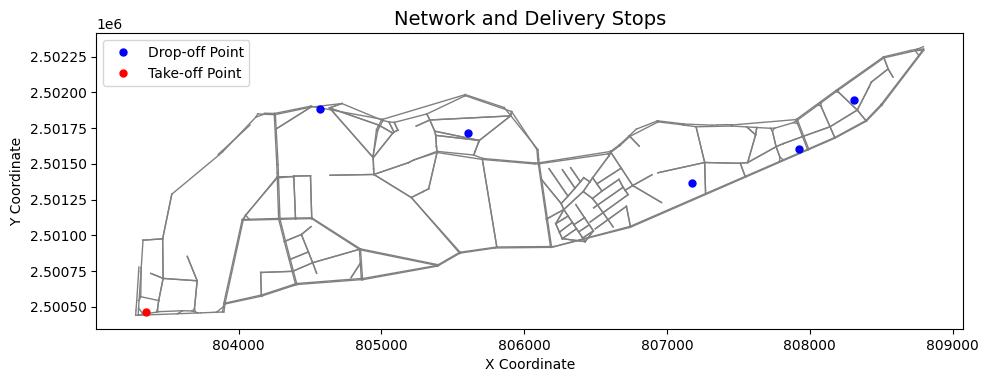

In [40]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

def parse_network(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    nodes = {}
    links = []

    for node in root.findall(".//node"):
        node_id = node.get("id")
        x = float(node.get("x"))
        y = float(node.get("y"))
        nodes[node_id] = (x, y)
    
    for link in root.findall(".//link"):
        from_node = link.get("from")
        to_node = link.get("to")
        if from_node in nodes and to_node in nodes:
            x1, y1 = nodes[from_node]
            x2, y2 = nodes[to_node]
            links.append(((x1, y1), (x2, y2)))
    
    return nodes, links

def parse_stops(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    stops = []

    for stop in root.findall(".//stopFacility"):
        stop_id = stop.get("id")
        x = float(stop.get("x"))
        y = float(stop.get("y"))
        stops.append((stop_id, x, y))
    
    return stops

def plot_network_and_stops(network_file, stops_file):
    print("Parsing network...")
    nodes, links = parse_network(network_file)

    print("Parsing stops...")
    stops = parse_stops(stops_file)

    print("Plotting...")
    fig, ax = plt.subplots(figsize=(10, 10))

    # 绘制路网连线
    for (x1, y1), (x2, y2) in links:
        ax.plot([x1, x2], [y1, y2], color='gray', linewidth=1)

    # 绘制 stop 点
    for stop_id, x, y in stops:
        if stop_id == "stop_5":
            ax.plot(x, y, 'ro', label="Take-off Point", markersize=5)  # 红色
        elif stop_id == "stop_4":
            ax.plot(x, y, 'bo', label="Drop-off Point", markersize=5)  # 蓝色
        else:
            ax.plot(x, y, 'bo', markersize=5)  # 蓝色

    # 图例和美化
    ax.set_title("Network and Delivery Stops", fontsize=14)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_aspect("equal")
    ax.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# 使用示例（替换为你的实际文件名）
plot_network_and_stops("cropped_network.xml", "custom_stops.xml")


In [45]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from pyproj import Transformer
import xml.etree.ElementTree as ET
from datetime import timedelta

# 起点经纬度
origin_lat, origin_lng = 22.5844, 113.9504

# 坐标转换器（WGS84 → EPSG:32649）
transformer_to_proj = Transformer.from_crs("EPSG:4326", "EPSG:32649", always_xy=True)

# 投影后的起点
origin_x, origin_y = transformer_to_proj.transform(origin_lng, origin_lat)
origin_proj_point = Point(origin_x, origin_y)

# 加载 geojson 地图并转换为投影坐标
gdf = gpd.read_file("map.geojson").to_crs("EPSG:32649")

# 参数设置
num_agents = 100
radius_step = 10         # 每圈增加 10 米
max_radius = 10000       # 最大搜索半径
collected_points = []

# 生成圆环上的点，并判断是否落在区域内
radius = radius_step
while len(collected_points) < num_agents and radius <= max_radius:
    circumference = 2 * np.pi * radius
    num_points = max(int(circumference / 10), 8)
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

    for angle in angles:
        x = origin_x + radius * np.cos(angle)
        y = origin_y + radius * np.sin(angle)
        point = Point(x, y)
        if gdf.contains(point).any():
            collected_points.append((x, y))
            if len(collected_points) >= num_agents:
                break
    radius += radius_step

print(f"✅ 生成 {len(collected_points)} 个目标点")


def seconds_to_HHMM(seconds):
    total_minutes = int(seconds // 60)
    hours = total_minutes // 60
    minutes = total_minutes % 60
    return f"{hours:02d}:{minutes:02d}"
# 构建符合 MATSim DTD 的 XML
population = ET.Element("population", attrib={"desc": "population written from streaming"})

for i, (x, y) in enumerate(collected_points):
    person = ET.SubElement(population, "person", id=f"order_{i+1}")
    plan = ET.SubElement(person, "plan", selected="yes")

    start_time = i * 86400 / num_agents  # 在 24 小时内平均分布

    ET.SubElement(plan, "activity", type="home", x=str(origin_x), y=str(origin_y),
                  end_time=seconds_to_HHMM(start_time))
    ET.SubElement(plan, "leg", mode="drt")  # 可改为 bike、walk 等
    ET.SubElement(plan, "activity", type="work", x=str(x), y=str(y))

# 写入 XML 文件
tree = ET.ElementTree(population)
with open("plans.xml", "wb") as f:
    f.write(b'<?xml version="1.0" encoding="utf-8"?>\n')
    f.write(b'<!DOCTYPE population SYSTEM "http://www.matsim.org/files/dtd/population_v6.dtd">\n')
    tree.write(f, encoding="utf-8")

print("✅ 已生成符合 MATSim 格式的 plans.xml")


✅ 生成 100 个目标点
✅ 已生成符合 MATSim 格式的 plans.xml


In [46]:
#检查路网的联通性
import xml.etree.ElementTree as ET
import networkx as nx

def check_network_connectivity(network_file):
    tree = ET.parse(network_file)
    root = tree.getroot()
    
    G = nx.DiGraph()
    
    for link in root.findall(".//link"):
        from_node = link.get("from")
        to_node = link.get("to")
        G.add_edge(from_node, to_node)
    
    print("Number of strongly connected components:", nx.number_strongly_connected_components(G))
    if not nx.is_strongly_connected(G):
        print("Network is not fully connected!")
    else:
        print("Network is fully connected.")

check_network_connectivity("cropped_network.xml")


Number of strongly connected components: 12
Network is not fully connected!


In [47]:
import xml.etree.ElementTree as ET
import networkx as nx
import math
from itertools import combinations

def parse_network(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    nodes = {}
    links = []
    for node in root.findall(".//node"):
        nid = node.get("id")
        x = float(node.get("x"))
        y = float(node.get("y"))
        nodes[nid] = (x, y)
    
    for link in root.findall(".//link"):
        links.append((link.get("id"), link.get("from"), link.get("to")))
    
    return nodes, links, tree, root

def build_graph(links):
    G = nx.DiGraph()
    for _, from_node, to_node in links:
        G.add_edge(from_node, to_node)
    return G

def euclidean(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

def connect_subnetworks(nodes, G, root):
    sccs = list(nx.strongly_connected_components(G))
    print(f"Total SCCs: {len(sccs)}")

    bridges = []
    next_link_id = 1000000
    for (i, scc1), (j, scc2) in combinations(enumerate(sccs), 2):
        min_dist = float("inf")
        min_pair = (None, None)
        for n1 in scc1:
            for n2 in scc2:
                d = euclidean(nodes[n1], nodes[n2])
                if d < min_dist:
                    min_dist = d
                    min_pair = (n1, n2)

        n1, n2 = min_pair
        x1, y1 = nodes[n1]
        x2, y2 = nodes[n2]
        # 添加两个双向 link（从 n1->n2 和 n2->n1）
        for from_id, to_id in [(n1, n2), (n2, n1)]:
            link_id = f"bridge_{next_link_id}"
            next_link_id += 1
            ET.SubElement(
                root.find(".//links"),
                "link",
                id=link_id,
                from_=from_id,
                to=to_id,
                length=str(euclidean(nodes[from_id], nodes[to_id])),
                freespeed="100",
                capacity="10000",
                permlanes="1",
                modes="car"
            )
            bridges.append((from_id, to_id))
    
    print(f"Added {len(bridges)} artificial links to bridge subnetworks.")
    return root

def save_network(tree, output_file):
    tree.write(output_file, encoding="utf-8", xml_declaration=True)
    print(f"Saved connected network to: {output_file}")

# 主函数
def connect_network_components(input_network="cropped_network.xml", output_network="cropped_connected_network.xml"):
    nodes, links, tree, root = parse_network(input_network)
    G = build_graph(links)
    new_root = connect_subnetworks(nodes, G, root)
    save_network(tree, output_network)

# 运行
connect_network_components()


Total SCCs: 12
Added 132 artificial links to bridge subnetworks.
Saved connected network to: cropped_connected_network.xml


In [51]:
import xml.etree.ElementTree as ET
import pyproj
import numpy as np
from shapely.geometry import Point, Polygon
import geopandas as gpd
import random
from datetime import timedelta

# 起点（WGS84）
origin_lat, origin_lng = 22.5844, 113.9504

# 坐标转换器：WGS84 -> EPSG:32649
wgs84 = pyproj.CRS("EPSG:4326")
utm = pyproj.CRS("EPSG:32649")
projector = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True)

origin_x, origin_y = projector.transform(origin_lng, origin_lat)

# 读取 GeoJSON 边界，转换为 EPSG:32649 坐标
def load_boundary(filename="map.geojson"):
    gdf = gpd.read_file(filename)
    gdf = gdf.to_crs("EPSG:32649")
    return gdf.unary_union

boundary = load_boundary()
buffered_boundary = boundary.buffer(-100)  # 100 米内缩，防止靠边出错

# 生成均匀点（每隔 10 米的一圈）
def generate_points(origin_x, origin_y, max_radius=3000, step=10):
    points = []
    radius = step
    while radius <= max_radius:
        num_points = int(2 * np.pi * radius / step)
        angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
        for angle in angles:
            x = origin_x + radius * np.cos(angle)
            y = origin_y + radius * np.sin(angle)
            p = Point(x, y)
            if buffered_boundary.contains(p):
                points.append((x, y))
        radius += step
    return points

# 生成 agent 的出发时间，平均分布在一天内
def generate_times(n):
    total_seconds = 24 * 3600
    interval = total_seconds // n
    return [timedelta(seconds=i * interval) for i in range(n)]

# 生成 plan.xml 文件
def write_plan_xml(origin, targets, times, output_file="plan.xml"):
    population = ET.Element("population", attrib={"desc": "population written from streaming"})

    for i, ((x, y), time) in enumerate(zip(targets, times)):
        person = ET.SubElement(population, "person", id=f"order_{i+1}")
        plan = ET.SubElement(person, "plan", selected="yes")
        
        # 起点活动
        ET.SubElement(plan, "activity", type="home", x=str(origin[0]), y=str(origin[1]), end_time=f"{int(time.total_seconds() // 3600):02d}:{int((time.total_seconds() % 3600) // 60):02d}")
        # leg
        ET.SubElement(plan, "leg", mode="drt")
        # 终点活动
        ET.SubElement(plan, "activity", type="work", x=str(x), y=str(y))

    # 写入 XML 文件
    tree = ET.ElementTree(population)
    with open(output_file, "wb") as f:
        f.write(b'<?xml version="1.0" encoding="utf-8"?>\n')
        f.write(b'<!DOCTYPE population SYSTEM "http://www.matsim.org/files/dtd/population_v6.dtd">\n')
        tree.write(f, encoding="utf-8")

# 主流程
if __name__ == "__main__":
    print("正在生成配送点...")
    target_points = generate_points(origin_x, origin_y)

    print(f"成功生成 {len(target_points)} 个配送点")
    times = generate_times(len(target_points))

    print("正在生成 plan.xml...")
    write_plan_xml((origin_x, origin_y), target_points, times)
    print("plan.xml 已生成 ✅")


/tmp/ipykernel_277557/334244580.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  return gdf.unary_union


正在生成配送点...
成功生成 24637 个配送点
正在生成 plan.xml...
plan.xml 已生成 ✅


In [54]:
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.cluster import DBSCAN
import networkx as nx

def process_network(input_file, output_file, eps=1.0):
    # 解析XML文件
    tree = ET.parse(input_file)
    root = tree.getroot()

    # 解析节点
    nodes = {}
    for node in root.findall('./nodes/node'):
        node_id = node.get('id')
        x = float(node.get('x'))
        y = float(node.get('y'))
        nodes[node_id] = (x, y)

    # 解析链接
    links = []
    for link in root.findall('./links/link'):
        link_data = {
            'id': link.get('id'),
            'from': link.get('from'),
            'to': link.get('to'),
            'length': link.get('length'),
            'freespeed': link.get('freespeed'),
            'capacity': link.get('capacity'),
            'permlanes': link.get('permlanes'),
            'oneway': link.get('oneway'),
            'modes': link.get('modes'),
            'attributes': {}
        }
        # 解析属性
        attributes = link.find('./attributes')
        if attributes is not None:
            for attr in attributes.findall('attribute'):
                name = attr.get('name')
                cls = attr.get('class')
                value = attr.text
                link_data['attributes'][name] = {'class': cls, 'value': value}
        links.append(link_data)

    # 节点聚类合并
    coords = np.array([(x, y) for x, y in nodes.values()])
    db = DBSCAN(eps=eps, min_samples=1).fit(coords)
    labels = db.labels_

    # 创建新节点集合
    new_nodes = {}
    node_map = {}
    for idx, (node_id, (x, y)) in enumerate(nodes.items()):
        label = labels[idx]
        if label not in new_nodes:
            # 创建新节点ID并计算平均坐标
            new_id = f"c{label}"
            cluster_points = coords[labels == label]
            avg_x = np.mean(cluster_points[:, 0])
            avg_y = np.mean(cluster_points[:, 1])
            new_nodes[new_id] = (avg_x, avg_y)
        node_map[node_id] = new_id

    # 处理链接
    valid_links = []
    for link in links:
        try:
            from_node = node_map[link['from']]
            to_node = node_map[link['to']]
            
            # 跳过自环链接
            if from_node == to_node:
                continue
                
            # 计算新长度
            x1, y1 = new_nodes[from_node]
            x2, y2 = new_nodes[to_node]
            new_length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
            
            # 创建新链接
            new_link = {
                'from': from_node,
                'to': to_node,
                'length': new_length,
                'id': link['id'],
                'freespeed': link['freespeed'],
                'capacity': link['capacity'],
                'permlanes': link['permlanes'],
                'oneway': link['oneway'],
                'modes': link['modes'],
                'attributes': link['attributes']
            }
            valid_links.append(new_link)
        except KeyError:
            continue

    # 去重链接
    unique_links = {}
    for link in valid_links:
        key = (link['from'], link['to'])
        if key not in unique_links:
            unique_links[key] = link
    dedup_links = list(unique_links.values())

    # 构建网络图
    G = nx.DiGraph()
    G.add_nodes_from(new_nodes.keys())
    for link in dedup_links:
        G.add_edge(link['from'], link['to'])

    # 获取最大连通组件
    scc = list(nx.strongly_connected_components(G))
    largest = max(scc, key=len)
    valid_nodes = largest

    # 过滤节点和链接
    final_nodes = {n: new_nodes[n] for n in valid_nodes}
    final_links = [link for link in dedup_links 
                  if link['from'] in valid_nodes and link['to'] in valid_nodes]

    # 创建新的XML结构
    new_root = ET.Element('network')
    
    # 添加坐标系属性
    attr_elem = ET.SubElement(new_root, 'attributes')
    crs = ET.SubElement(attr_elem, 'attribute', 
                       {'name': 'coordinateReferenceSystem', 'class': 'java.lang.String'})
    crs.text = root.find('.//attribute[@name="coordinateReferenceSystem"]').text

    # 添加处理后的节点
    nodes_elem = ET.SubElement(new_root, 'nodes')
    for nid, (x, y) in final_nodes.items():
        ET.SubElement(nodes_elem, 'node', {'id': nid, 'x': str(x), 'y': str(y)})

    # 添加处理后的链接
    links_elem = ET.SubElement(new_root, 'links', {
        'capperiod': root.find('./links').get('capperiod'),
        'effectivecellsize': root.find('./links').get('effectivecellsize'),
        'effectivelanewidth': root.find('./links').get('effectivelanewidth')
    })
    
    for link in final_links:
        link_elem = ET.SubElement(links_elem, 'link', {
            'id': link['id'],
            'from': link['from'],
            'to': link['to'],
            'length': str(link['length']),
            'freespeed': link['freespeed'],
            'capacity': link['capacity'],
            'permlanes': link['permlanes'],
            'oneway': link['oneway'],
            'modes': link['modes']
        })
        
        # 添加额外属性
        if link['attributes']:
            attr_elem = ET.SubElement(link_elem, 'attributes')
            for name, data in link['attributes'].items():
                ET.SubElement(attr_elem, 'attribute', 
                            {'name': name, 'class': data['class']}).text = data['value']

    # 保存新文件
    tree = ET.ElementTree(new_root)
    tree.write(output_file, encoding='utf-8', xml_declaration=True)

if __name__ == "__main__":
    process_network('cropped_network.xml', 'processed_network.xml', eps=1.0)

In [55]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
from shapely.geometry import Point
import datetime
import statsmodels.api as sm
import random

# -------------------------------
# 1. 参数设定
# -------------------------------
restaurant_lng, restaurant_lat = 113.9504, 22.5844
N_total = 1000  # 总订单数量，可修改

# -------------------------------
# 2. 加载GeoJSON并分颜色分类
# -------------------------------
gdf = gpd.read_file("classified_map.geojson")

# 颜色到权重的映射
color_weight_map = {
    "#4657dd": 4,
    "#555555": 4,
    "#c4c4c4": 2
}

# 分类并打上标签
gdf['weight'] = gdf['fill'].map(color_weight_map)
gdf = gdf.dropna(subset=['weight'])

# 按颜色分类
color_groups = gdf.groupby('fill')

# -------------------------------
# 3. 生成顾客位置函数（根据权重比例随机抽取polygon）
# -------------------------------
def generate_customer_locations_weighted(num_points):
    polygons = gdf.geometry.tolist()
    weights = gdf['weight'].tolist()
    norm_weights = np.array(weights) / sum(weights)

    points = []
    while len(points) < num_points:
        # 按权重选择一个polygon
        selected_polygon = np.random.choice(polygons, p=norm_weights)

        # 在polygon内生成随机点
        minx, miny, maxx, maxy = selected_polygon.bounds
        for _ in range(10):  # 尝试10次
            pnt = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
            if selected_polygon.contains(pnt):
                points.append((pnt.x, pnt.y))
                break
    return points

# -------------------------------
# 4. 时间逻辑（非齐次泊松）保持不变
# -------------------------------
data_path = "all_waybill_info_meituan.csv"  # 替换为你的路径
data = pd.read_csv(data_path)
data = data[data['fetch_time'] != 0]
data['fetch_time'] = pd.to_datetime(data['fetch_time'], unit='s') + pd.Timedelta(hours=8)
first_day = data['fetch_time'].min().normalize()
data = data[data['fetch_time'] > first_day]
data['minute_of_day'] = data['fetch_time'].dt.hour * 60 + data['fetch_time'].dt.minute
num_days = data['fetch_time'].dt.normalize().nunique()
minute_counts = data.groupby('minute_of_day').size().reset_index(name='count')
minute_counts['lambda'] = minute_counts['count'] / num_days

# 傅里叶级数拟合
num_harmonics = 6
minute_counts['const'] = 1
for k in range(1, num_harmonics + 1):
    minute_counts[f'sin_{k}'] = np.sin(2 * np.pi * k * minute_counts['minute_of_day'] / 1440)
    minute_counts[f'cos_{k}'] = np.cos(2 * np.pi * k * minute_counts['minute_of_day'] / 1440)

X = minute_counts[['const'] + [f'sin_{k}' for k in range(1, num_harmonics + 1)] +
                   [f'cos_{k}' for k in range(1, num_harmonics + 1)]]
y = minute_counts['count']
poisson_model = sm.GLM(y, X, family=sm.families.Poisson(), offset=np.log(num_days) * np.ones_like(y))
poisson_results = poisson_model.fit()
minute_counts['lambda_est'] = poisson_results.predict(X) / num_days
minute_counts['p_t'] = minute_counts['lambda_est'] / np.sum(minute_counts['lambda_est'])

# -------------------------------
# 5. 最终生成订单
# -------------------------------
def generate_preparation_time():
    return np.random.randint(5, 16)  # 5~15分钟之间随机

order_records = []
orders_per_minute = np.random.multinomial(N_total, minute_counts['p_t'].values)
start_time = datetime.datetime(2025, 3, 21, 0, 0)

time = 0
for num_orders in orders_per_minute:
    current_time = start_time + datetime.timedelta(minutes=time)
    customer_locations = generate_customer_locations_weighted(num_orders)

    for customer in customer_locations:
        preparation_time = generate_preparation_time()
        ready_time = current_time + datetime.timedelta(minutes=preparation_time)

        order_records.append([
            current_time.strftime("%H:%M"),
            customer[0], customer[1],
            restaurant_lng, restaurant_lat,
            preparation_time,
            ready_time.strftime("%H:%M")
        ])
    time += 1

# 保存结果
df_orders = pd.DataFrame(order_records, columns=["order_time", "customer_lng", "customer_lat", "restaurant_lng", "restaurant_lat", "preparation_time", "ready_time"])
df_orders.to_csv("generated_orders.csv", index=False)
print("CSV 文件 'generated_orders.csv' 生成完毕！")
print(df_orders.head(3))


/home/bld/.local/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 33 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


CSV 文件 'generated_orders.csv' 生成完毕！
  order_time  customer_lng  customer_lat  restaurant_lng  restaurant_lat  \
0      00:01    113.993823     22.593027        113.9504         22.5844   
1      00:02    113.953408     22.586125        113.9504         22.5844   
2      00:04    113.960699     22.588020        113.9504         22.5844   

   preparation_time ready_time  
0                11      00:12  
1                11      00:13  
2                 7      00:11  


In [56]:
#plan.xml生成
import pandas as pd
import pyproj
from lxml import etree

def convert_coordinates(lng, lat):
    """将WGS84坐标转换为EPSG:32649坐标系。"""
    transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:32649", always_xy=True)
    return transformer.transform(lng, lat)

def generate_matsim_plan(csv_file, output_xml):
    """从CSV文件生成MATSim的plan.xml文件。"""
    df = pd.read_csv(csv_file)
    
    # 创建XML根节点
    population = etree.Element("population", desc="population written from streaming")
    
    for index, row in df.iterrows():
        person = etree.SubElement(population, "person", id=f"order_{index+1}")
        plan = etree.SubElement(person, "plan", selected="yes")
        
        # 餐厅坐标转换
        home_x, home_y = convert_coordinates(row["restaurant_lng"], row["restaurant_lat"])
        
        # 顾客坐标转换
        work_x, work_y = convert_coordinates(row["customer_lng"], row["customer_lat"])
        
        # 订单时间和出餐时间
        ready_time = row["ready_time"]
        
        # home activity (餐厅)
        activity_home = etree.SubElement(plan, "activity", type="home", x=str(home_x), y=str(home_y), end_time=ready_time)
        
        # leg (配送)
        leg = etree.SubElement(plan, "leg", mode="drt")
        
        # work activity (顾客地址)
        activity_work = etree.SubElement(plan, "activity", type="work", x=str(work_x), y=str(work_y))
    
    # 生成XML文件
    tree = etree.ElementTree(population)
    tree.write(output_xml, pretty_print=True, xml_declaration=True, encoding="utf-8")
    
    print(f"MATSim plan.xml 文件已生成: {output_xml}")

# 使用示例
generate_matsim_plan("generated_orders.csv", "plan_shenzhen442.xml")

MATSim plan.xml 文件已生成: plan_shenzhen442.xml
